# <center> Projet4 : Anticipez les besoins en consommation électrique de bâtiments
    
    Notebook Analysis

**Introduction** : 

Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Notre mission dans ce projet consiste à réaliser les diverses modélisations grâce à des approches linéaires et non-linéaire afin de prédire les émissions de CO2 et les consommations d'énergie des bâtiments non-résidentiels.

# 1. Importation des modules et données

La première chose que nous devrons faire est de charger les bibliothèques et les jeu de données que nous utiliserons.

In [1]:
import pandas as pd 
from numpy import arange
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import stats
from ast import literal_eval 
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset1 = pd.read_csv("C:\\Users\Marwa\Downloads\projet4\\2015-building-energy-benchmarking.csv\\2015-building-energy-benchmarking.csv", encoding='utf-8', low_memory=False)
dataset2 = pd.read_csv("C:\\Users\Marwa\Downloads\projet4\\2016-building-energy-benchmarking.csv\\2016-building-energy-benchmarking.csv", encoding='utf-8', low_memory=False)

In [3]:
#Créer des copies à nettoyer
dataset_2015=dataset1.copy()
dataset_2016=dataset2.copy()

# 2. Fonctions

## 2.1 Fonctions : Nettoyage des données

In [4]:
#read a csv file 
def read_file(path):
  file= pd.read_csv(path, encoding='utf-8', low_memory=False)
  return file

#dataset shape
def shape_dataset(dataset):
    nb_rows, nb_columns = dataset.shape
    print("Dataset a {} lignes et {} colonnes".format(nb_rows, nb_columns))

#taux de remplissage total 
def taux_de_remplissage(dataset):

   nb_rows, nb_columns = dataset.shape
   #taux total de remplissage 
   fill_data= (dataset.count().sum() / (nb_rows * nb_columns))
   print("le taux total de remplissage est: {:.2%}" .format( fill_data))
   
   #taux total des données manquantes 
   miss_data= (dataset.isna().sum().sum() / (nb_rows * nb_columns))
   print("le taux total des données manquantes est: {:.2%}" .format( miss_data))
   return fill_data, miss_data

## 2.2 Fonctions : Analyse descriptive

In [5]:
#vérifier si les colonnes de deux datasets sont communs 
def common_columns(dataset1, dataset2):
   return set(dataset1.columns)== set(dataset2.columns)

#liste des colonnes communs et différentes entre les deux datasets 
def different_columns(dataset1, dataset2):
   
  commun_cols = []   #liste pour stocker les colonnes de dataset1 qui sont dans dataset2
  diff_cols1=[] #liste pour stocker les colonnes de dataset1 qui ne sont pas dans dataset2
  diff_cols2=[] #liste pour stocker les colonnes de dataset2 qui ne sont pas dans dataset1
  commun_cols =set(dataset1.columns & dataset2.columns)
  diff_cols1= set(set(dataset1.columns) - set(commun_cols))
  diff_cols2= set(set(dataset2.columns) - set(commun_cols))
  return diff_cols1,  diff_cols2, commun_cols

#cette fonction retourne la liste des colonnes vides dans une dataset
def empty_columns(dataset): 

    colonnes_vides=[]
    for column in dataset.columns:
       if dataset[column].isnull().all():
           colonnes_vides.append(column) 
    return colonnes_vides
#renommer une liste des colonnes 
def rename_cols ( dataset,rename_columns):
   dataset= dataset.rename(columns=rename_columns)
   return dataset

#taux de remplissage par colonne 
def col_remplissage(dataset):
   data_stat=pd.DataFrame(index=['filling rate', 'missing rate'], columns=dataset.columns )
   for col in dataset.columns:
      nb_nan=dataset[col].isnull().sum()
      data_stat.loc['filling rate', col]= (dataset.shape[0]-nb_nan)/(dataset.shape[0]*1.0)
      data_stat.loc['missing rate', col]= nb_nan/(dataset.shape[0]*1.0)
      return data_stat


# 3. Description des données

Dans ce projet nous avons deux jeux de données pour les années 2015 et 2016 :

## 3.1 Forme

In [6]:
#shape of dataset_2015
shape_dataset(dataset_2015)
#shape of dataset_2016
shape_dataset(dataset_2016)

Dataset a 3340 lignes et 47 colonnes
Dataset a 3376 lignes et 46 colonnes


## 3.2 Qualité

La première chose à faire avec un jeu de données est d'en jeter un coup d'œil. Cela permet de voir que tout est lu correctement et donne une idée de ce qui se passe avec les données.


In [6]:
dataset_2015.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,...,NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
count,3340.000000,3340.0,3340.000000,3340.000000,3340.000000,3332.000000,3.340000e+03,3340.000000,3.340000e+03,3.204000e+03,...,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3330.000000,224.000000,3338.000000,213.000000,3338.000000,3340.000000
mean,20522.168263,2015.0,4.450898,1967.624850,1.035629,4.682173,9.077289e+04,11054.032335,7.971886e+04,7.488154e+04,...,1.253304e+04,1.253304e+06,7.142301e+03,110.094102,0.985339,123.062500,32.380168,1.347418,24.825644,18786.680240
std,11511.515874,0.0,2.127203,32.949847,0.784463,5.458460,1.493058e+05,35296.330507,1.292314e+05,1.236249e+05,...,4.415142e+04,4.415142e+06,1.962790e+05,409.450179,1.637172,5.812128,19.907567,0.477272,15.006287,588.604192
min,1.000000,2015.0,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,-3.000000,-5.055000e+04,5.872000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,116.000000,1.000000,1.000000,1.000000,17916.000000
25%,19921.750000,2015.0,3.000000,1947.000000,1.000000,2.000000,2.848700e+04,0.000000,2.668300e+04,2.500000e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,9.265000,0.080000,117.000000,14.000000,1.000000,10.000000,18379.000000
50%,22977.000000,2015.0,4.000000,1973.000000,1.000000,4.000000,4.385500e+04,0.000000,4.132600e+04,3.900000e+04,...,2.945500e+03,2.945770e+05,0.000000e+00,32.740000,0.460000,123.000000,33.000000,1.000000,26.000000,18390.000000
75%,25748.000000,2015.0,7.000000,1996.000000,1.000000,5.000000,8.842800e+04,4304.250000,7.872600e+04,7.206750e+04,...,1.115325e+04,1.115366e+06,0.000000e+00,88.642500,1.180000,125.500000,50.000000,2.000000,38.000000,19576.000000
max,50059.000000,2015.0,7.000000,2015.000000,39.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,...,1.364484e+06,1.364484e+08,8.269669e+06,11824.890000,31.380000,135.000000,61.000000,2.000000,51.000000,19584.000000


In [7]:
dataset_2016.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,...,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,...,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,...,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,...,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,...,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,...,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,...,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


Il semble qu'il y a des données manquantes ! 
Il pourrait être utile de voir quel pourcentage des valeurs de notre jeu de données manquait pour nous donner une meilleure idée de l'ampleur de ce problème :

**Données manquantes :**

Les données manquantes sont répresentées généralement par NaN ou None.

In [43]:
fill_data, miss_data=taux_de_remplissage(dataset_2015)

le taux total de remplissage est: 88.74%
le taux total des données manquantes est: 11.26%


In [44]:
fill_data, miss_data=taux_de_remplissage(dataset_2016)

le taux total de remplissage est: 89.09%
le taux total des données manquantes est: 10.91%


#### Données dupliquées

In [56]:
#afficher le nombre des lignes duplicated
dataset_2015.duplicated().sum() 
dataset_2016.duplicated().sum()

0

**Comparaison des colonnes entre le deux jeux de données**

Nous allons commencer à vérifier si les deux jeux de données ayant les mêmes colonnes dans le but de faire une concaténation de deux jeux des données et avoir finalement un seul dataset qui sera plus simple à traiter.

In [7]:
common_columns(dataset_2015, dataset_2016)

False

In [8]:
diff_cols1,  diff_cols2, commun_cols= different_columns(dataset_2015, dataset_2016)
print(set(diff_cols1))
print(set(diff_cols2))
print(set(commun_cols))

{'Location', 'City Council Districts', 'Comment', 'Seattle Police Department Micro Community Policing Plan Areas', 'SPD Beats', 'Zip Codes', '2010 Census Tracts', 'GHGEmissions(MetricTonsCO2e)', 'OtherFuelUse(kBtu)', 'GHGEmissionsIntensity(kgCO2e/ft2)'}
{'Address', 'Comments', 'GHGEmissionsIntensity', 'State', 'City', 'Longitude', 'Latitude', 'TotalGHGEmissions', 'ZipCode'}
{'Electricity(kBtu)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'PropertyName', 'Electricity(kWh)', 'PrimaryPropertyType', 'SecondLargestPropertyUseType', 'DataYear', 'NaturalGas(therms)', 'NumberofFloors', 'LargestPropertyUseType', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'NaturalGas(kBtu)', 'NumberofBuildings', 'ListOfAllPropertyUseTypes', 'OSEBuildingID', 'SourceEUIWN(kBtu/sf)', 'TaxParcelIdentificationNumber', 'SiteEnergyUseWN(kBtu)', 'ThirdLargestPropertyUseType', 'CouncilDistrictCode', 'BuildingType', 'LargestPropertyUseTypeGFA', 'Neighborhood', 'ThirdLargestPropertyUseTypeGFA', 'SourceEUI(k

Nous constatons que les colonnes ne sont pas les mémes entre les deux datasets 2015 et 2016

Passons à vérifier quels colonnes sont différentes :

In [9]:
print(len(commun_cols), "colonnes présentes dans le fichier 2015 et le fichier 2016 sont :\n")
commun_cols

37 colonnes présentes dans le fichier 2015 et le fichier 2016 sont :



{'BuildingType',
 'ComplianceStatus',
 'CouncilDistrictCode',
 'DataYear',
 'DefaultData',
 'ENERGYSTARScore',
 'Electricity(kBtu)',
 'Electricity(kWh)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'ListOfAllPropertyUseTypes',
 'NaturalGas(kBtu)',
 'NaturalGas(therms)',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'OSEBuildingID',
 'Outlier',
 'PrimaryPropertyType',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'PropertyGFATotal',
 'PropertyName',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SteamUse(kBtu)',
 'TaxParcelIdentificationNumber',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearBuilt',
 'YearsENERGYSTARCertified'}

In [60]:
print(len(diff_cols1),"colonnes présentes dans le fichier 2015 et absentes du fichier 2016 sont :\n")
diff_cols1

10 colonnes présentes dans le fichier 2015 et absentes du fichier 2016 sont :



{'2010 Census Tracts',
 'City Council Districts',
 'Comment',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Location',
 'OtherFuelUse(kBtu)',
 'SPD Beats',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'Zip Codes'}

In [61]:
print(len(diff_cols2),"colonnes présentes dans le fichier 2016 et absentes du fichier 2015 sont :\n")
diff_cols2

9 colonnes présentes dans le fichier 2016 et absentes du fichier 2015 sont :



{'Address',
 'City',
 'Comments',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'State',
 'TotalGHGEmissions',
 'ZipCode'}

## Bilan de description 

Après une phase d'observation de jeu des données, on a eu une description globale des datasets.

**On trouve plusieurs types des variables** 

 variables concernent **les surfaces** 
- GFA(Gross floor area):La surface de plancher totale contenue dans le bâtiment 
- PropertyGFABuilding(s) : surface des bâtiments
- PropertyGFAParking : surface des parkings
- ListOfAllPropertyUseTypes : les différentes utilisations des surfaces (Hotel, Parking, Restaurant, Piscine, etc.)
- LargestPropertyUseType / LargestPropertyUseTypeGFA : principale utilisation du bâtiment et de sa surface.
- SecondLargestPropertyUseType / SecondLargestPropertyUseTypeGFA : seconde utilisation du bâtiment et de sa surface
- ThirdLargestPropertyUseType / ThirdLargestPropertyUseTypeGFA : troisième utilisation du bâtiment et de sa surface.

Variables concernet **l'énergie**
- ENERGYSTARScore: fournit un aperçu complet de la performance énergétique d'un bâtiment et  il est exprimé sur une échelle de 1 à 100.  Plus le score est élevé, meilleure est la performance énergétique du bâtiment. Cela aider à identifier les bâtiments à cibler pour une amélioration.  
- SiteEUI(kBtu/sf) - SiteEUIWN(kBtu/sf): exprime la consommation d'énergie d'un bâtiment en fonction de sa taille ou d'autres caractéristiques. 
- SourceEUI(kBtu/sf) - SourceEUIWN(kBtu/sf): est l'unité d'évaluation la plus équitable pour comparer différents bâtiments entre eux. représente la quantité totale de combustible brut nécessaire au fonctionnement du bâtiment. 
- SiteEnergyUse(kBtu): est la consommation d'énergie du site d'une propriété divisée par sa surface de plancher brute.
- SiteEnergyUseWN(kBtu): L'intensité de consommation d'énergie du site (EUI) normalisée par les conditions météorologiques (WN) est l'énergie du site WN d'une propriété divisée par sa surface de plancher brute (en pieds carrés)

- Electricity(kWh) - Electricity(kBtu): la quantité annuelle d'électricité consommée par le bien sur place, y compris l'électricité achetée sur le réseau et produite par des systèmes renouvelables sur place, mesurée en kWh et kBtu
- NaturalGas(therms) - NaturalGas(kBtu): La quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en thermes et kBtu.
- GHGEmissions(MetricTonsCO2e):The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu. "
- GHGEmissionsIntensity(kgCO2e/ft2): \t\nTotal Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources"


**Après exploration, nous constatons que:**

- la variable 'comments' de dataset 2016 correspond à la variable 'comment' de dataset 2015.
- la variable 'TotalGHGEmissions' de dataset 2016 correspond à la variable 'GHGEmissions(MetricTonsCO2e)' de dataset 2015 donc on a doit renomer une de deux colonnes. 
- la variable 'GHGEmissionsIntensity' de dataset 2016 correspond à la variable 'GHGEmissionsIntensity(kgCO2e/ft2)' de dataset 2015 donc on doit renomer une de deux colonnes.  
- les variables 'Address', 'City', 'Latitude', 'Longitude' de dataset 2015 se rèfèrent à la variable 'Location' de dataset 2015.
- La variable ZipCode de dataset 2016 == la variable 'Zip Codes' de dataset 2015 donc on a doit renomer une de deux colonnes. 

**Renommer les colonnes dans dataset 2015** 

In [10]:
#renomer les colonnes 
rename_columns={ 'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity','GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions'}
dataset_2015=dataset_2015.rename(columns=rename_columns)

# 4. Nettoyage des données

## 4.1 Suppression des colonnes vides

Nous allons commencer notre nettoyage par la suppression des colonnes totalement vides.

In [11]:
empty_columns (dataset_2015)
empty_columns (dataset_2016)
dataset_2016= dataset_2016.drop(columns='Comments', axis=1)

In [12]:
print(dataset_2015['Comment'].isnull().sum())
dataset_2015= dataset_2015.drop(columns='Comment', axis=1)

3327


## 4.2 Décompression de la colonne 'Location'

In [13]:
#afficher la prémière ligne de la variable 'Location'
dataset_2015['Location'].values[0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

Voila, les colonnes 'Address', 'City', 'Latitude', 'Longitude' , 'State' et 'City', de dataset 2016 sont inclus dans dataset 2015 comme des valeurs de la variable 'Location'. 

Donc notre prochaine pas est de décompresser la variable 'Location' puis la supprimer pour avoir les meme variables avec dataset 2016. 

In [14]:
shape_dataset(dataset_2015)
data1= dataset_2015['Location'].map(literal_eval).apply(pd.Series)
data2= data1['human_address'].map(literal_eval).apply(pd.Series)
data1= data1.drop(columns= 'human_address', axis=1)
data= pd.concat([data1, data2], axis=1)
dataset_2015=pd.concat([dataset_2015, data], axis=1)

#supprimer la colonne Location
dataset_2015=dataset_2015.drop(columns= 'Location', axis=1)
shape_dataset(dataset_2015)

Dataset a 3340 lignes et 46 colonnes
Dataset a 3340 lignes et 51 colonnes


**Vérifions à ce stade si les deux datasets ayant les memes colonnes** 

In [15]:
diff_cols_list1,  diff_cols_list2, commun_cols= different_columns(dataset_2015, dataset_2016)
print(diff_cols_list1)

{'City Council Districts', 'SPD Beats', 'latitude', 'Seattle Police Department Micro Community Policing Plan Areas', 'Zip Codes', 'city', '2010 Census Tracts', 'state', 'zip', 'OtherFuelUse(kBtu)', 'longitude', 'address'}


Nous allons supprimer à ce stade les colonnes non pertinantes au projet.

In [16]:
rename_cols= {'latitude':'Latitude', 'state': 'State', 'address':'Address', 'zip': 'ZipCode','city': 'City', 'longitude': 'Longitude'}
drop_cols=['2010 Census Tracts', 'Zip Codes', 'City Council Districts', 'Seattle Police Department Micro Community Policing Plan Areas', 'SPD Beats', 'OtherFuelUse(kBtu)']

dataset_2015=dataset_2015.rename(columns=rename_cols)
dataset_2015= dataset_2015.drop(columns= drop_cols, axis=1)

## 4.3 Types des données

Les variables de deux jeux de données sont maintenant identiques, vérifions si les types des variables sont identiques ou non

In [17]:
pd.concat([dataset_2015.dtypes, dataset_2016.dtypes], axis=1)

,0,1
OSEBuildingID,int64,int64
DataYear,int64,int64
BuildingType,object,object
PrimaryPropertyType,object,object
PropertyName,object,object
TaxParcelIdentificationNumber,object,object
CouncilDistrictCode,int64,int64
Neighborhood,object,object
YearBuilt,int64,int64
NumberofBuildings,int64,float64


**Modifier les types de données** 

In [18]:
dataset_2015[['Latitude','Longitude', 'ZipCode', 'NumberofBuildings']] = dataset_2015[['Latitude','Longitude', 'ZipCode', 'NumberofBuildings']].astype('float64')
dataset_2016['NumberofFloors']=dataset_2016['NumberofFloors'].astype(float)

In [19]:
print(dataset_2015.shape)
print(dataset_2016.shape)

(3340, 45)
(3376, 45)


**Dataset la plus récente** 

On va annuler l'étape de concaténation et on travaillera juste sur le dataset la plus récente "dataset_2016"

## 4.4 Remplissage total des données

In [21]:
dataset = dataset_2016

In [22]:
fill_data, miss_data= taux_de_remplissage(dataset)

le taux total de remplissage est: 89.09%
le taux total des données manquantes est: 10.91%


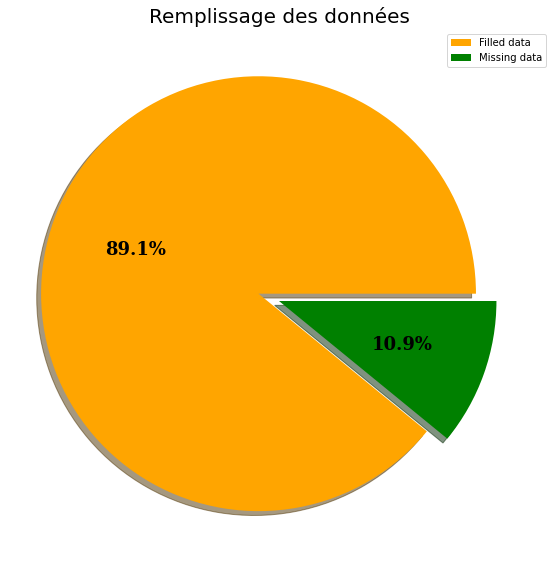

In [23]:
#Plotting pie chart
font_title = {'family': 'serif',
              'color':  'black',
              'weight': 'bold',
              'size': 18}
explodes = np.zeros(2)
explodes[0] = .1
labels = ["Filled data", "Missing data"]
fig, axe = plt.subplots(figsize=(10, 10))
frequencies = [fill_data, miss_data]
plt.title("Remplissage des données", fontsize=20)            
axe.pie(frequencies, autopct='%1.1f%%',  startangle=0, 
        shadow=True,
        explode=explodes, colors= ['orange', 'green'],
        textprops=font_title)
plt.legend(labels)
plt.show()

**Remplissage par colonne**

In [24]:
data_stat=pd.DataFrame(index=['filling rate', 'missing rate'], columns=dataset.columns )
for col in dataset.columns:
    nb_nan=dataset[col].isnull().sum()
    data_stat.loc['filling rate', col]= (dataset.shape[0]-nb_nan)/(dataset.shape[0]*1.0)
    data_stat.loc['missing rate', col]= nb_nan/(dataset.shape[0]*1.0)
data_stat

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
filling rate,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995261,1.0,...,0.997334,0.997334,0.997334,0.997334,0.997334,1.0,1.0,0.009479,0.997334,0.997334
missing rate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004739,0.0,...,0.002666,0.002666,0.002666,0.002666,0.002666,0.0,0.0,0.990521,0.002666,0.002666


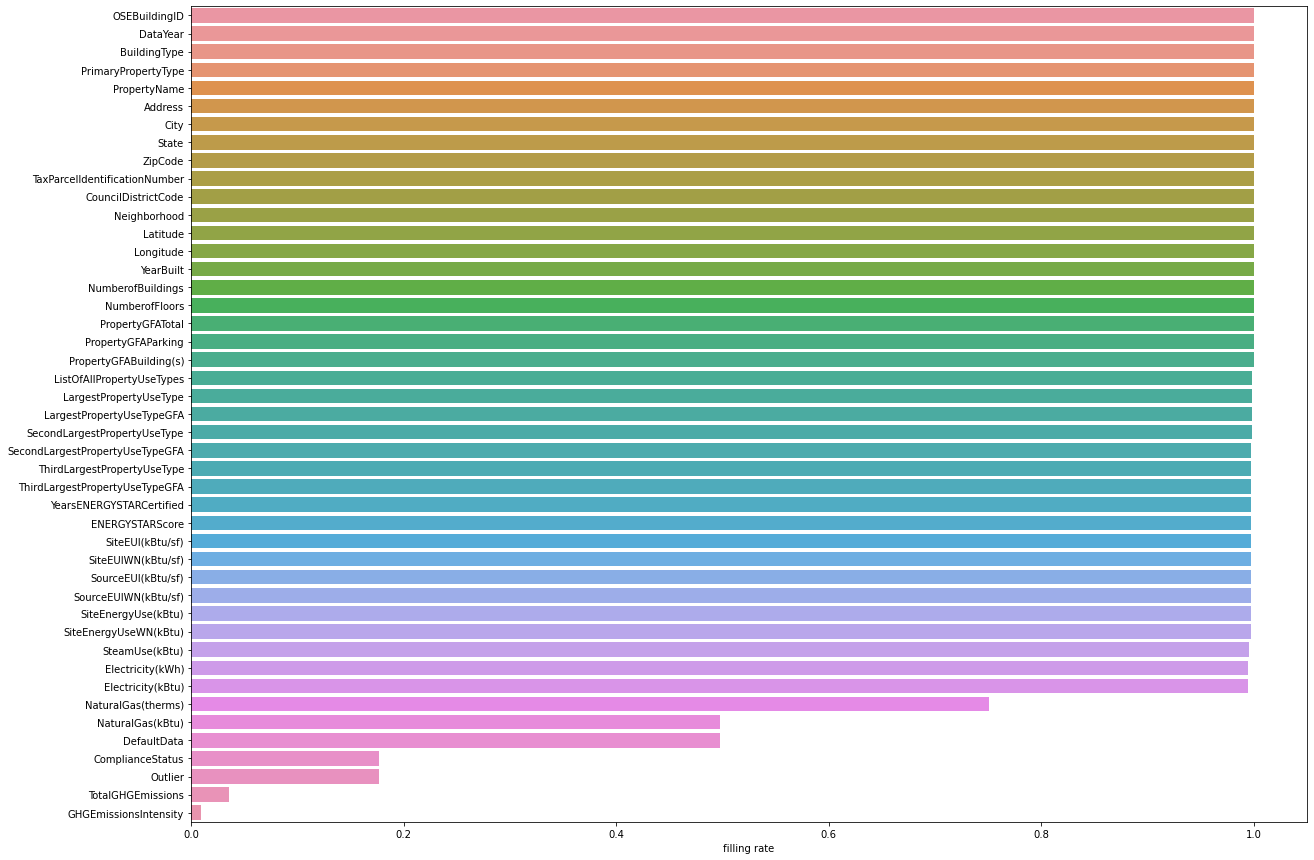

In [25]:
from IPython.core.pylabtools import figsize
fig, axe = plt.subplots(figsize=(20, 15))
sns.barplot(y= dataset.columns, x= data_stat.loc['filling rate'].sort_values( ascending=False))
plt.show()


**Seuil de remplissage**

In [26]:
#supprimer les colonnes ayant un taux de remplissage inférieure à un pourcentage 60%
def drop_col_remplissage (pourcentage):
   deleted_list=[]
   for col in dataset.columns: 
      if data_stat.loc['filling rate', col] < pourcentage:
          deleted_list.append(col)
   return deleted_list

deleted_list=drop_col_remplissage(0.6)
deleted_list

['SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'Outlier']

In [27]:
#afficher les valeurs uniques de unique_list
unique_list= ['State','Outlier', 'Address','TaxParcelIdentificationNumber', 'PropertyName' , 'DefaultData', 'BuildingType', 
       'Neighborhood','ComplianceStatus', 'NumberofBuildings', 'NumberofFloors']
for col in unique_list:
  print(col)
  print(dataset[col].unique())


State
['WA']
Outlier
[nan 'High outlier' 'Low outlier']
Address
['405 Olive way' '724 Pine street' '1900 5th Avenue' ... '1920 1st Ave W'
 '8319 8th Ave S' '2820 S Myrtle St']
TaxParcelIdentificationNumber
['0659000030' '0659000220' '0659000475' ... '1624049080' '7883603155'
 '7857002030']
PropertyName
['Mayflower park hotel' 'Paramount Hotel' '5673-The Westin Seattle' ...
 'Queen Anne Pool' 'South Park Community Center'
 'Van Asselt Community Center']
DefaultData
[False  True]
BuildingType
['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']
Neighborhood
['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'Central' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'CENTRAL' 'SOUTHWEST' 'DELRIDGE' 'Ballard' 'North' 'Delridge'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']
ComplianceStatus
['Compliant' 'Error - Correct Default Data' 'Missing Data' 'Non-Complian

In [28]:
#je vais considérer que les lignes dans lequels la variable 'outlier' contient les valeurs 'Heigh outlier'sont des lignes aberantes et doivent etre supprimer. 
dataset = dataset[dataset['Outlier'] != 'High Outlier']
dataset= dataset.drop(columns=deleted_list, axis=1).reset_index()

- Les deux colonnes 'State' et 'City' ayant une seule valeurs, alors on doit les supprimer
- les deux colonne 'DefaultData' et 'Address' parait non utile, on va le supprimer 
- les deux colonnes 'TaxParcelIdentificationNumber', 'PropertyName' sont identiques à la variable ID, on va les supprimer

In [29]:
dataset=dataset.drop(columns=['City', #la variable City a la même valeur dans tous les lignes 
                              'State', #la variable State a la même valeur dans tous les lignes 
                              'TaxParcelIdentificationNumber', #similaire à ID
                              'PropertyName', #similaire à ID
                              'DefaultData', #non utile 
                              'Address', #non utile 
                              ], axis=1)

In [30]:
#remplacer 'Missing Data' et 'Error - Correct Default Data' par NAN value
dataset['ComplianceStatus'].replace('Missing Data', np.nan, inplace=True)
dataset['ComplianceStatus'].replace('Error - Correct Default Data', np.nan, inplace=True)
#remplacer les valeurs 0 ou NaN du nombre de bâtiments et d'étages par 0
replace_dict= {np.nan: 0}
dataset['NumberofBuildings'].replace(replace_dict, inplace=True)
dataset['NumberofFloors'].replace(replace_dict, inplace=True)
dataset['Neighborhood']= dataset['Neighborhood'].replace({'Ballard':'BALLARD', 'Central': 'CENTRAL', 'Delridge':'DELRIDGE','DELRIDGE NEIGHBORHOODS':'DELRIDGE', 'North': 'NORTH', 'Northwest': 'NORTHEAST'})

**On s'interesse seulement aux bâtiments non résidentiels** 

Nous allons, donc, éliminer toutes les lignes correspondant à des locaux résidentiels (ici 'Multifamily) en se basant sur la variable **BuildingType**

In [31]:
residential_list= dataset['BuildingType'].str.contains('Multifamily')
dataset= dataset[~residential_list]
dataset['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [32]:
sorted(dataset['PrimaryPropertyType'].unique())

['Distribution Center',
 'Hospital',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Large Office',
 'Low-Rise Multifamily',
 'Medical Office',
 'Mixed Use Property',
 'Office',
 'Other',
 'Refrigerated Warehouse',
 'Residence Hall',
 'Restaurant',
 'Retail Store',
 'Self-Storage Facility',
 'Senior Care Community',
 'Small- and Mid-Sized Office',
 'Supermarket / Grocery Store',
 'University',
 'Warehouse',
 'Worship Facility']

on constate ici qu'il ya des doublons avec un espace ou un saut de ligne:

**exemple:** ('Self-Storage Facility\n' et 'Self-Storage Facility' )ou  ('Supermarket / Grocery Store' et 'Supermarket/Grocery Store')

In [28]:
dataset['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       nan, 'Library', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Retail Store', 'Senior Care Community',
       'Medical Office', 'Hospital (General Medical & Surgical)',
       'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Multifamily Housing', 'Worship Facility', 'Laboratory',
       'Supermarket/Grocery Store', 'Convention Center',
       'Urgent Care/Clinic/Other Outpatient', 'Other - Services',
       'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

In [33]:
dataset['ListOfAllPropertyUseTypes'] #non utile
dataset.drop(columns='ListOfAllPropertyUseTypes', axis=1, inplace=True)

Je vais créer six catégories ' Entertainment', Education, Health, Office,  Retail et wirehouse: 

Mon but est de minimiser les nombres de colonnes:

In [34]:
Entertainment_dict= {'Restaurant':'Entertainment', 'Museum':'Entertainment', 'Other - Entertainment/Public Assembly':'Entertainment', 'Movie Theater':'Entertainment'
              ,'Social/Meeting Hall':'Entertainment','Food Service':'Entertainment','Personal Services (Health/Beauty, Dry Cleaning, etc)':'Entertainment', 
              'Bar/Nightclub':'Entertainment',  'Other - Recreation':'Entertainment', 'Fitness Center/Health Club/Gym':'Entertainment',
              'Food Sales':'Entertainment','Worship Facility':'Entertainment', 'Parking':'Entertainment', 'Other - Restaurant/Bar':'Entertainment','Lifestyle Center': 'Entertainment', 'Other - Utility': 'Entertainment', 'Swimming Pool':'Entertainment' ,'Fast Food Restaurant':'Entertainment','Performing Arts':'Entertainment'}
        
Education_dict ={'Other - Education':'Education', 'Library':'Education','Adult Education':'Education', 
                 'Vocational School':'Education', 'Pre-school/Daycare':'Education','University':'Education', 'Other - Technology/Science': 'Education', 'Fitness Center/Health Club/Gym, Office, Other - Recreation, Other - Technology/Science': 'Education',
                 'K-12 School':'Education', 'College/University':'Education', 'Residence Hall': 'Education', 'Other - Technology/Science ':'Education' }            
Health_dict={'Medical Office': 'health','Other/Specialty Hospital': 'health', 'Outpatient Rehabilitation/Physical Therapy': 'health' ,'Urgent Care/Clinic/Other Outpatient': 'health', 'Senior Care Community': 'health', 'Hospital':'health', 'Hospital (General Medical & Surgical)':'health', 'Hospital (General Medical & Surgical)': 'health'}

office_dict ={'Laboratory, Non-Refrigerated Warehouse, Office, Other - Utility': 'Office', 
    'Small- and Mid-Sized Office':'Office', 'Financial Office': 'Office', 'Manufacturing/Industrial Plant': 'Office',  'Laboratory': 'Office', 'Residence Hall/Dormitory': 'Office', 'Fire Station': 'Office','Courthouse': 'Office' ,'Prison/Incarceration': 'Office', 'Police Station': 'Office','Large Office': 'Office','Other - Services': 'Office','Data Center': 'Office' ,'Bank Branch': 'Office',  'Other - Public Services': 'Office'}
Retrail_dict={'Personal Services':'Retial','Supermarket/Grocery Store':'Retial', 'Mixed Use Property':'Retial', 'Self-Storage Facility':'Retial' ,'Retail Store': 'Retial', 'Distribution Center':'Retial' ,'Convenience Store without Gas Station': 'Retial',
              'Enclosed Mall':'Retial','Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Retial', 'Strip Mall': 'Retial', 'Wholesale Club/Supercenter': 'Retial','Automobile Dealership': 'Retial','Other - Mall':'Retial'}

wirehouse_dict= {'Non-Refrigerated Warehouse':'Warehouse', 'Refrigerated Warehouse':'Warehouse'}

In [35]:
for column in ['LargestPropertyUseType','PrimaryPropertyType']:
    dataset[column].replace(Entertainment_dict, inplace=True)
    dataset[column].replace(Education_dict, inplace=True)
    dataset[column].replace(Health_dict, inplace=True)
    dataset[column].replace(office_dict, inplace=True)
    dataset[column].replace(Retrail_dict, inplace=True)
    dataset[column].replace(wirehouse_dict, inplace=True)

# 4.5 Outliers

Dans ce paragraphe, nous cherchons à identifier les valuers aberantes

In [36]:
#On repère les données catégoriques
données_categoriques= dataset.select_dtypes(exclude=["float64","int64"]).columns
#On repère les données numériques
données_numériques = dataset.select_dtypes(include=["float64","int64"]).columns

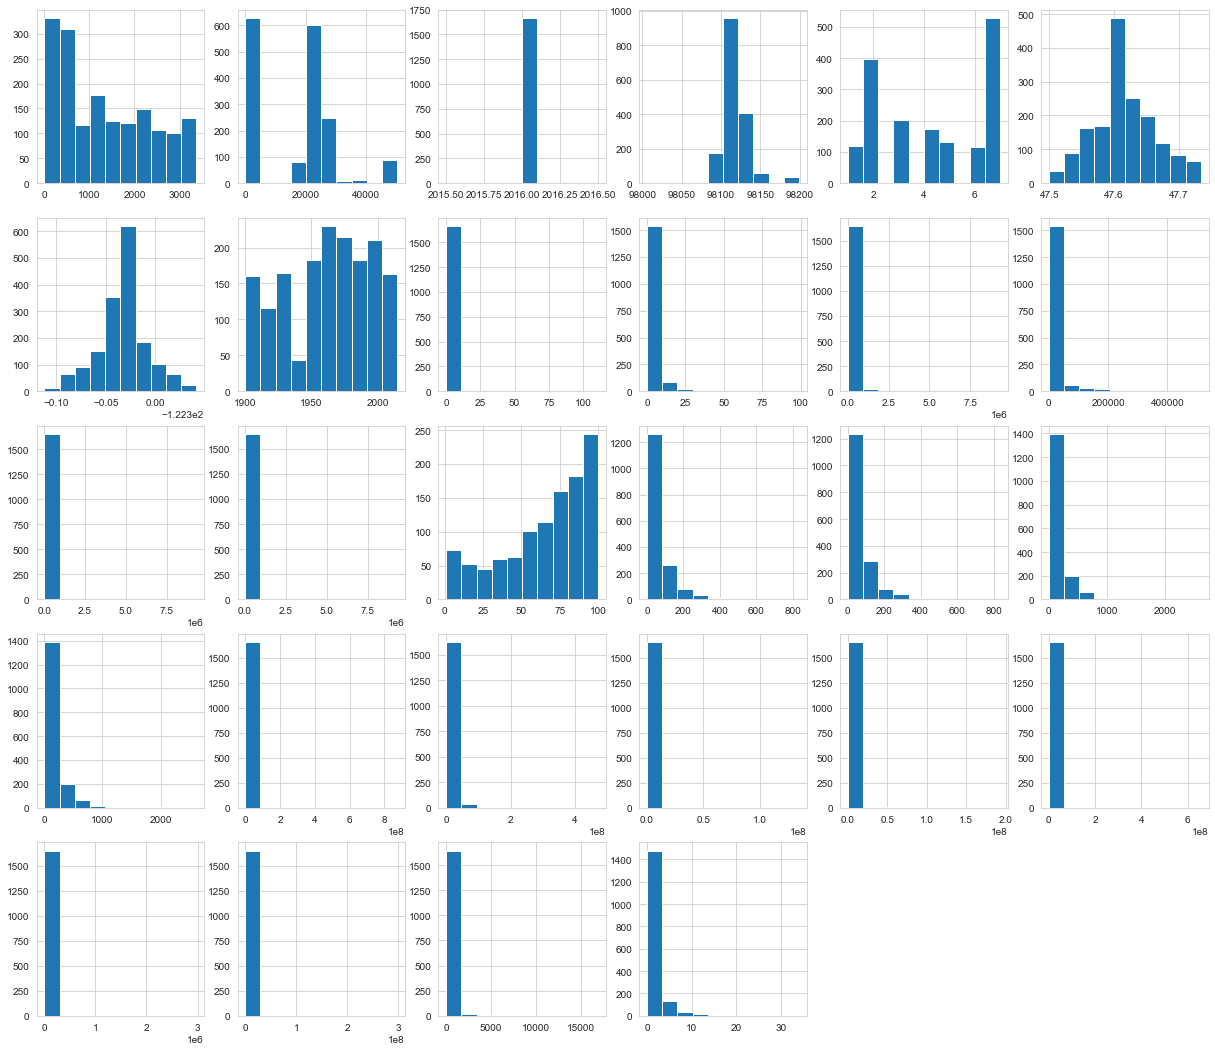

In [37]:
#histogramme 
sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,30))
def hist_plot(cols):
   for i in range (dataset[cols].shape[1]):
       fig.add_subplot(8,6, i+1)
       colonne= cols[i]
       plt.hist(dataset[colonne])
   plt.show()

hist_plot(données_numériques)



D'après ces histogrammes, on constate qu'il n'y a pas des valeurs aberrantes.

## 4.6 Imputation des données manquantes

In [38]:
#Imputation des données manquantes
def modeimputer(dataset, données_categoriques):
     dataset[données_categoriques]= dataset[données_categoriques].fillna(dataset[données_categoriques].mode().iloc[0])
     return dataset

def KNNimputer(dataset, données_numériques):
    imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
    imputer.fit(dataset[données_numériques])
    dataset[données_numériques]= imputer.transform(dataset[données_numériques])
    dataset[données_numériques]=pd.DataFrame(dataset[données_numériques], columns=données_numériques)
    return dataset

**Imputation des données qualitatives** 

In [39]:
dataset=modeimputer(dataset, données_categoriques)
dataset

,index,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,0,1,2016,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,...,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,Compliant,249.98,2.83
1,1,2,2016,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,...,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,Compliant,295.86,2.86
2,2,3,2016,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,...,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,Compliant,2089.28,2.19
3,3,5,2016,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,...,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,Compliant,286.43,4.67
4,4,8,2016,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,...,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,Compliant,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,3371,50222,2016,Nonresidential COS,Office,NaN,2,GREATER DUWAMISH,47.56722,-122.31154,...,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,Compliant,20.94,1.70
3372,3372,50223,2016,Nonresidential COS,Other,NaN,2,DOWNTOWN,47.59625,-122.32283,...,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,Compliant,32.17,2.01
3373,3373,50224,2016,Nonresidential COS,Other,NaN,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,...,5.765898e+06,6.053764e+06,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,Compliant,223.54,16.99
3374,3374,50225,2016,Nonresidential COS,Retial,NaN,1,GREATER DUWAMISH,47.52832,-122.32431,...,7.194712e+05,7.828413e+05,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,Compliant,22.11,1.57


**Imputation des données numériques**

In [40]:
from sklearn.impute import KNNImputer
dataset= KNNimputer(dataset, données_numériques)
dataset

,index,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,0.0,1.0,2016.0,NonResidential,Hotel,98101.0,7.0,DOWNTOWN,47.61220,-122.33799,...,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,Compliant,249.98,2.83
1,1.0,2.0,2016.0,NonResidential,Hotel,98101.0,7.0,DOWNTOWN,47.61317,-122.33393,...,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,Compliant,295.86,2.86
2,2.0,3.0,2016.0,NonResidential,Hotel,98101.0,7.0,DOWNTOWN,47.61393,-122.33810,...,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,Compliant,2089.28,2.19
3,3.0,5.0,2016.0,NonResidential,Hotel,98101.0,7.0,DOWNTOWN,47.61412,-122.33664,...,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,Compliant,286.43,4.67
4,4.0,8.0,2016.0,NonResidential,Hotel,98121.0,7.0,DOWNTOWN,47.61375,-122.34047,...,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,Compliant,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,3371.0,50222.0,2016.0,Nonresidential COS,Office,98114.2,2.0,GREATER DUWAMISH,47.56722,-122.31154,...,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,Compliant,20.94,1.70
3372,3372.0,50223.0,2016.0,Nonresidential COS,Other,98108.2,2.0,DOWNTOWN,47.59625,-122.32283,...,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,Compliant,32.17,2.01
3373,3373.0,50224.0,2016.0,Nonresidential COS,Other,98109.8,7.0,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,...,5.765898e+06,6.053764e+06,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,Compliant,223.54,16.99
3374,3374.0,50225.0,2016.0,Nonresidential COS,Retial,98113.6,1.0,GREATER DUWAMISH,47.52832,-122.32431,...,7.194712e+05,7.828413e+05,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,Compliant,22.11,1.57


In [41]:
dataset.drop(['index'], axis=1, inplace=True)

# 5. Analyse exploratoire

## 5.1 Analyse univariée

**Types des batiments**

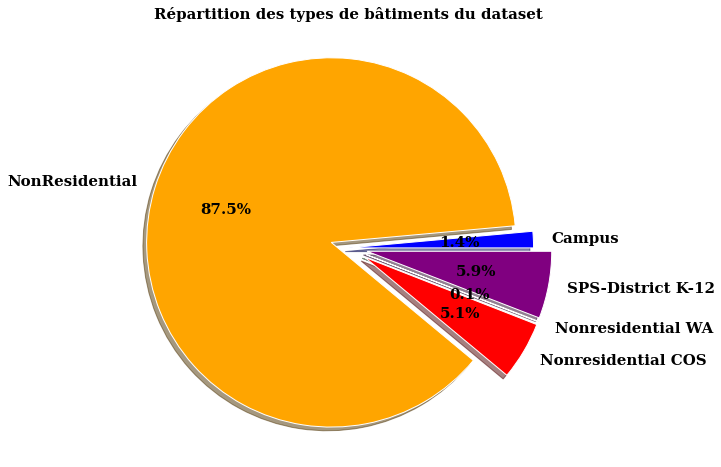

In [42]:
type_bat = dataset.groupby(by='BuildingType')['OSEBuildingID'].nunique()

font_title = {'family': 'serif',
              'color':  'black',
              'weight': 'bold',
              'size': 15}
explodes = (0.0, 0.1, 0.1, 0.1, 0.1)
#explodes[1] = .1
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(type_bat.values, labels=type_bat.index, 
       autopct='%1.1f%%', 
       textprops=font_title, shadow=True, colors=['blue','orange','red','green','purple'],
        explode=explodes)
ax.axis('equal')
ax.set_title("Répartition des types de bâtiments du dataset", fontdict=font_title)
plt.show()

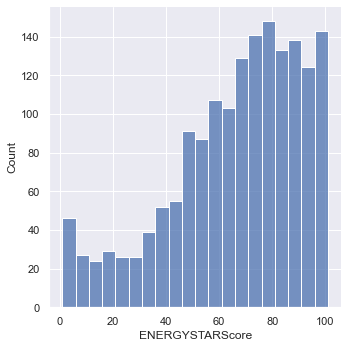

In [43]:
sns.set_theme()
sns.displot(dataset, x='ENERGYSTARScore', binwidth=5)

In [44]:
d= pd.DataFrame(columns= ["ENERGYSTARScore", 'class'])
d["ENERGYSTARScore"]=dataset['ENERGYSTARScore']
i=0
j=0
for val in dataset['ENERGYSTARScore'].values: 
  if val < 50:
     i+=1
  if val > 75:
     j+=1   
print('ENERGYSTARScore < 50', i)
print('ENERGYSTARScore >75',j) 

ENERGYSTARScore < 50 398
ENERGYSTARScore >75 699


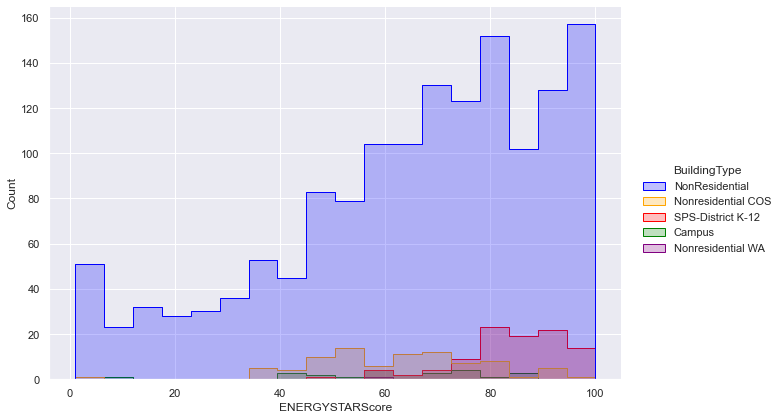

In [45]:
sns.displot(dataset, x='ENERGYSTARScore', hue='BuildingType', palette=['blue','orange','red','green','purple'],element="step", height=6,aspect=1.5)

In [46]:
données_numériques = dataset.select_dtypes(include=["float64","int64"]).columns
dataset[données_numériques].shape

(1668, 27)

## 5.2 Matrice de corrélation

In [47]:
#matrice de correlation
def matrice_corr(dataset):
    matrice_corr=dataset.corr()
    mask= np.triu(np.ones_like(matrice_corr))
#heatmap
    fig = plt.figure(figsize=(30,30))
    sns.heatmap(matrice_corr, square=True, linewidths=0.01, mask=mask,  annot=True, cmap='coolwarm')
    plt.title('Heatmap des corrélations', fontdict=font_title)
    
    return plt.show()
def pairplot(dataset, cols):
  #sns.set()
  sns.pairplot(dataset[cols], size = 2.5)
  plt.show()

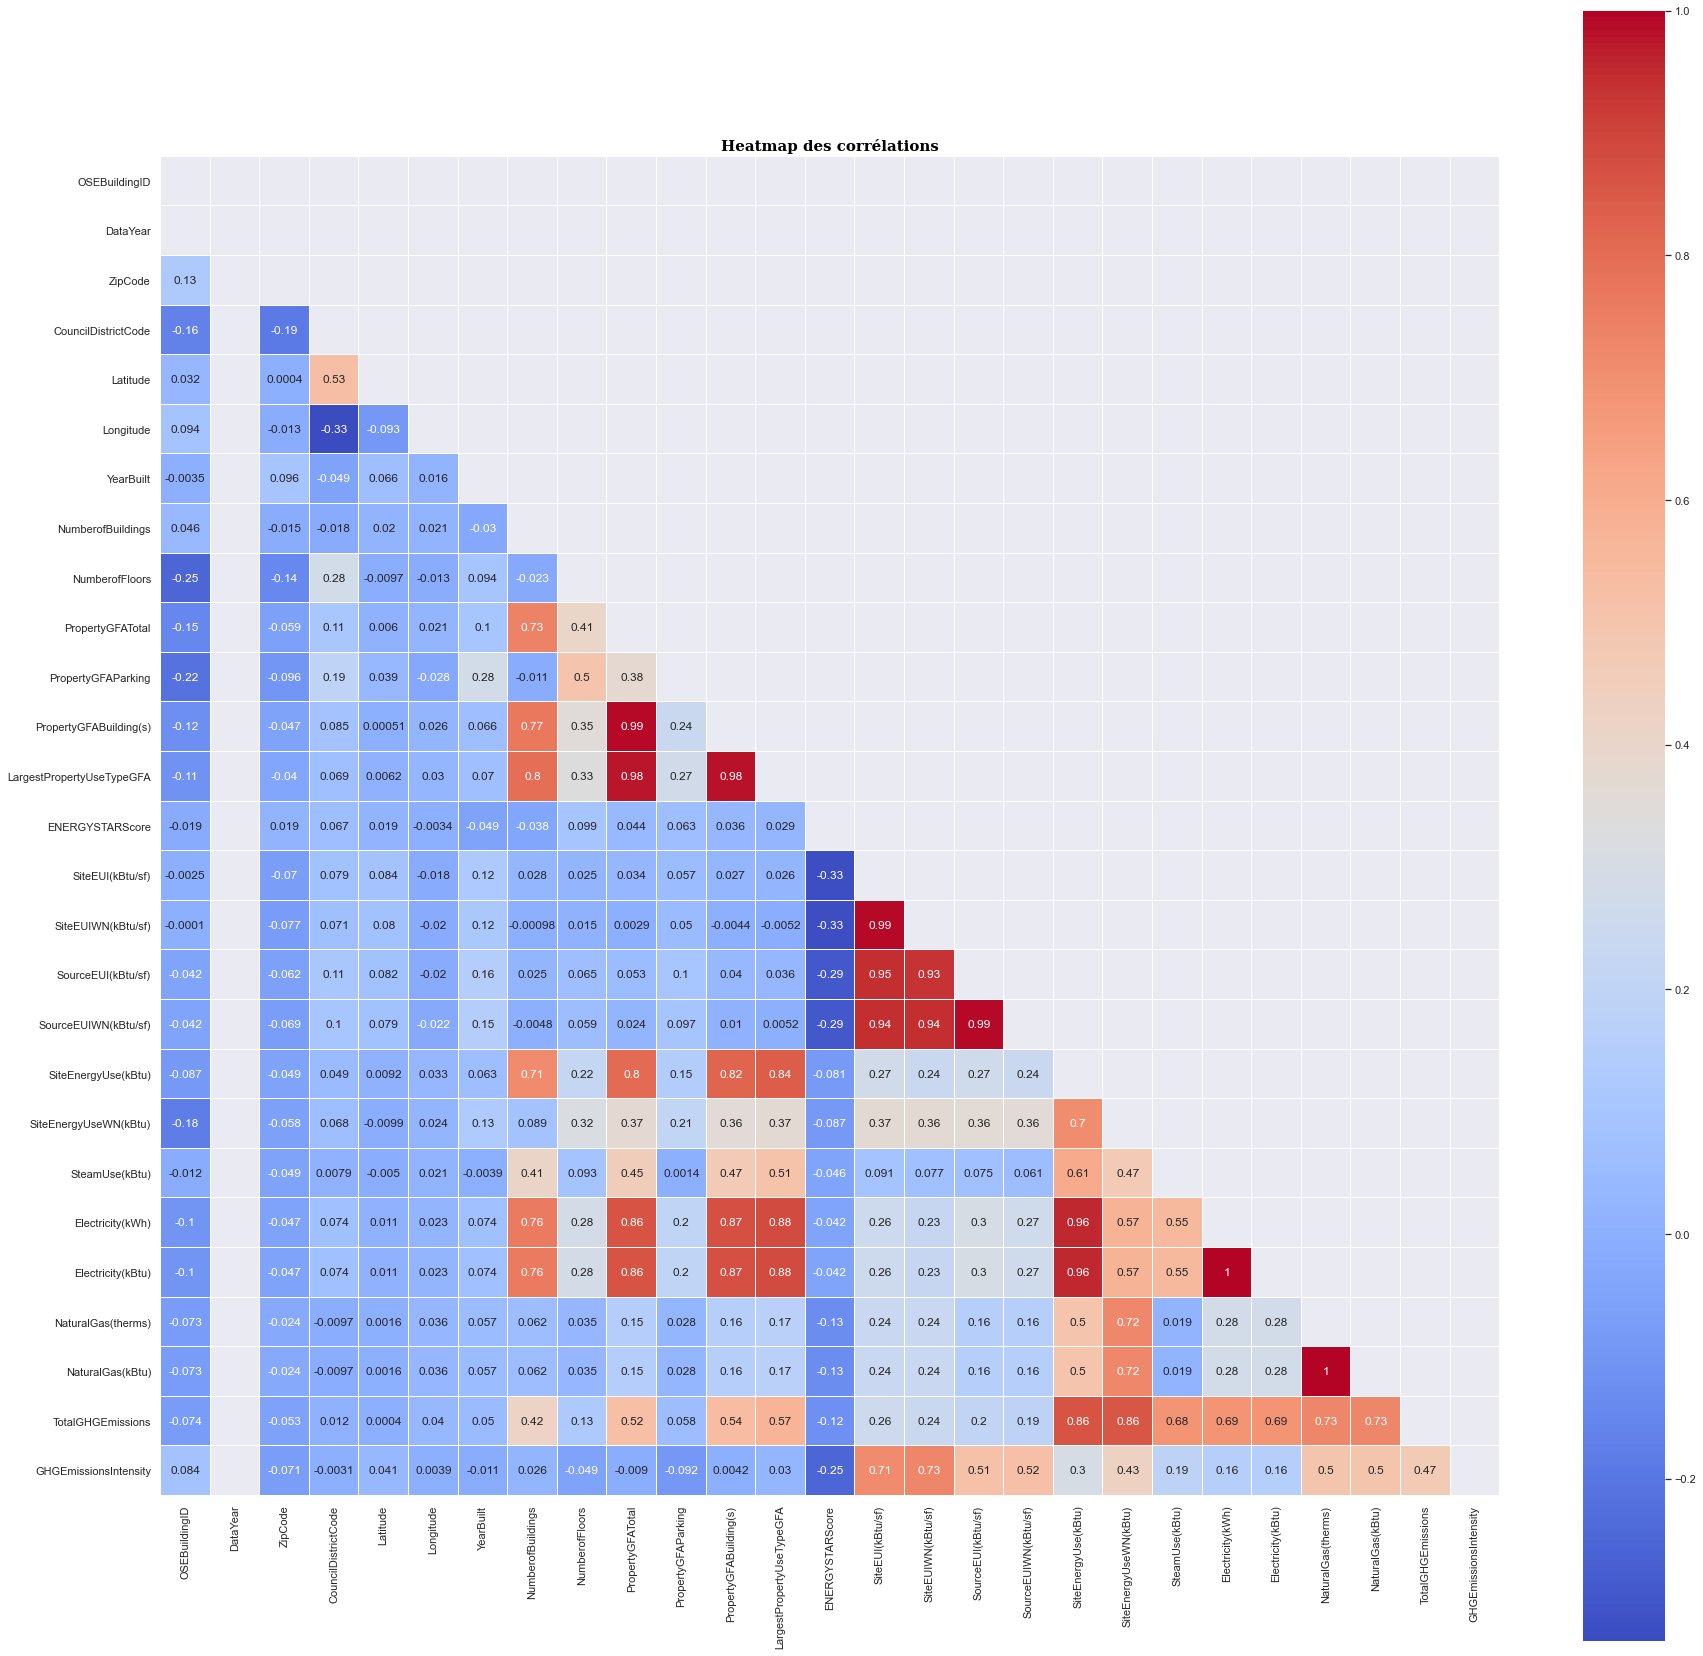

In [48]:
#matrice de corrélation 
matrice_corr(dataset)

**Observations**

On remarque sur ce Heatmap de fortes corrélations linéaires entre variables. Ces corrélations peuvent amener des problèmes de colinéarité dans nos futurs modèles.

- les variables 'Electricity(kWh)', 'Electricity(kBtu)' et 'NaturalGas(therms)','NaturalGas(kBtu)'et 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)' sont identiques (coéfficient de corrélation =1)
- Les deux variables 'SiteEUI(kBtu/sf)' et 'SiteEUIWN(kBtu/sf)' sont fortement corrélés( coéfficient de corrélation = 0.99)
- Les deux variables 'PropertyGFABuilding(s)' et ' LargestProUseTypeGFA' sont fortement corrélés avec la variable 'TotalGHGEmissions'.

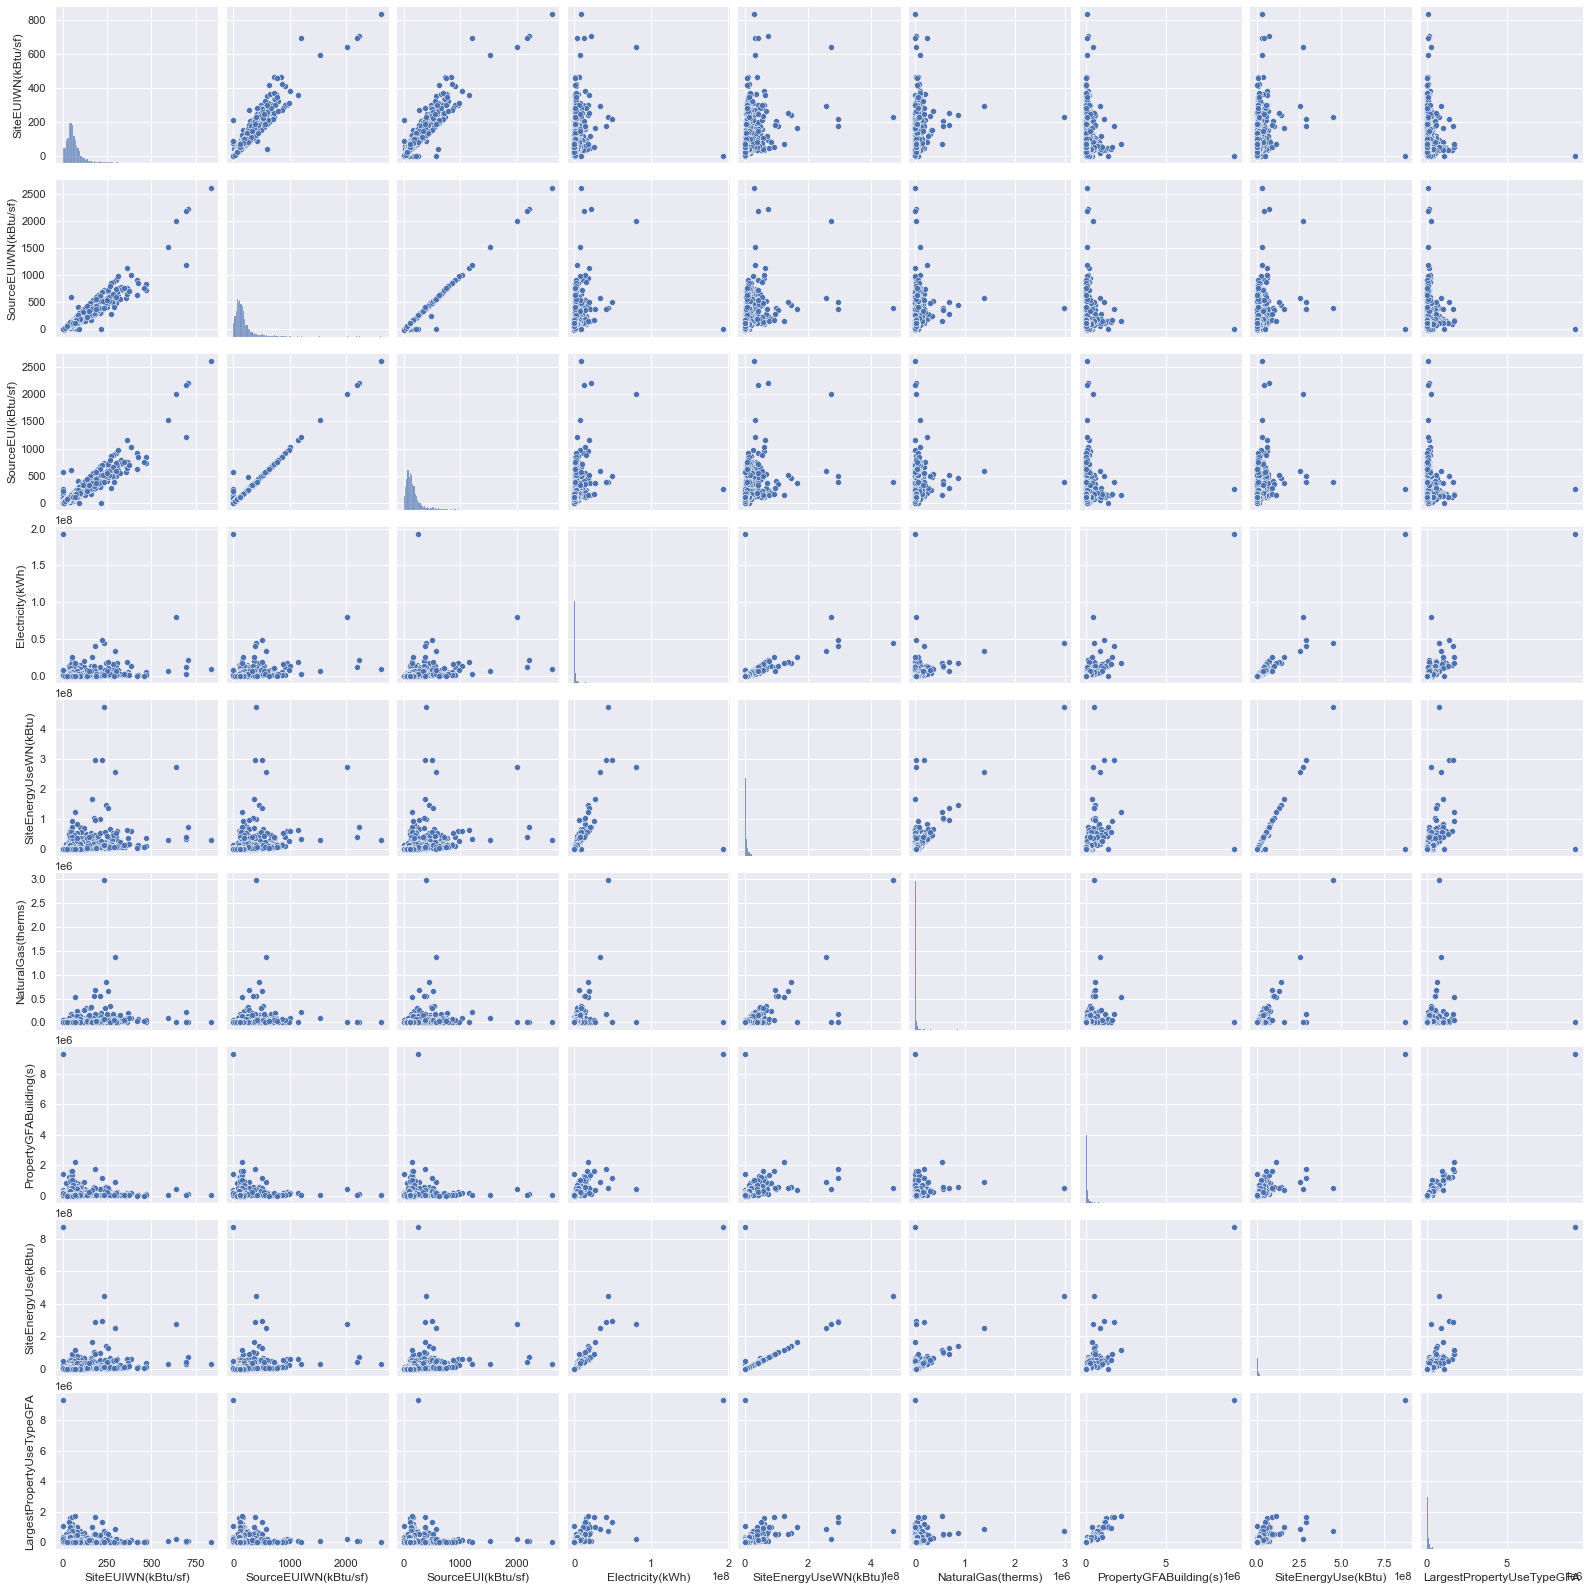

In [49]:
#scatterplot
sns.set()
cols = ['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 'Electricity(kWh)',
               'SiteEnergyUseWN(kBtu)', 'NaturalGas(therms)', 'PropertyGFABuilding(s)','SiteEnergyUse(kBtu)', 'LargestPropertyUseTypeGFA']
sns.pairplot(dataset[cols], size = 2.5)
plt.show()

**Interpretation**

   - Nous avons une corrélation entre: 
* 'SiteEnergyUse et SiteEnergyUseWN(kBtu)
* 'Electricity(kWh)' et 'Electricity(kBtu)'
* 'SiteEnergyUse(kBtu)' et 'SiteEnergyUseWN(kBtu)'
* 'SourceEUIWN(kBtu/sf)' et 'SourceEUI(kBtu/sf)'
* 'SourceEUI(kBtu/sf)' et 'SiteEUIWN(kBtu/sf)'


Suppression de quelques features fortement corrélées

In [50]:
to_drop_list= ['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)', 'NaturalGas(therms)',
               'Electricity(kWh)','SourceEUI(kBtu/sf)', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA']
dataset=dataset.drop(columns=to_drop_list, axis=1)

In [51]:
dataset=dataset.drop(columns= 'OSEBuildingID', axis=1)
dataset.columns.to_list()

['DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'LargestPropertyUseType',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'ComplianceStatus',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

Les features suffixées EUI(kBtu/sf), sont des variables dont les valeurs sont ramenées à la surface par étage. Nous allons les supprimer car nous avons créer des variables pouvant permettre de ramener nos données à l'étage ou au building. Idem pour la variable GHGEmissionsIntensity

In [52]:
dataset=dataset.drop(columns= ['GHGEmissionsIntensity','SiteEUI(kBtu/sf)'],axis =1)

In [53]:
#créer une nouvelle colonne BuildingAge= DataYear - YearBuilt
BuildAge= dataset['DataYear']- dataset['YearBuilt']
dataset['BuilAge']= BuildAge
#colonnes non pertinentes 
dataset=dataset.drop(columns= ['DataYear','YearBuilt', 'CouncilDistrictCode', 'ZipCode', 'YearBuilt', 'PropertyGFAParking',
                               'ComplianceStatus', 'Latitude', 'Longitude'], axis=1)

In [54]:
#Enregistrer dataset nettoyé
dataset.to_csv("C:\\Users\Marwa\Downloads\projet4\\dataset_2016_cleaned.csv")

In [55]:
dataset.shape

(1668, 14)

## 5.3 ACP : Analyse des composantes principales

L’ACP est une méthode exploratoire (i.e., descriptive) qui permet de décrire un jeu de données multivarié, de le résumer, d’en réduire la dimensionnalité. C'est une méthode d'analyse de données multivariée. Elle permet d'explorer des jeux de données multidimensionnels constitués de variables quantitatives.

On va l'utiliser dans cette partie pour faire une réduction dimensionnelle.

### 5.3.1 Preprocessing

#### Standardisation des données

In [56]:
dataset = pd.read_csv("C:\\Users\Marwa\Downloads\projet4\\dataset_2016_cleaned.csv")
dataset=dataset.drop(columns='Unnamed: 0', axis=1)

In [57]:
#On repère les données qualitatives et quantitatives 
données_numériques= dataset.select_dtypes(include=["float64","int64"]).columns
données_qualitatives = dataset.select_dtypes(exclude=["float64","int64"]).columns

In [58]:
#standardisation des données 
def standard(dataset, données_numériques):
    scaler = StandardScaler()
    scaler.fit(dataset[données_numériques])
    dataset[données_numériques] = scaler.transform(dataset[données_numériques])
    return dataset

In [59]:
from sklearn.preprocessing import StandardScaler
print(dataset.shape)
dataset= standard(dataset, données_numériques)
print(dataset.shape)

(1668, 14)
(1668, 14)


**Transformer les données qualitatives en données numériques : Méthode One Hot Encoder**

In [60]:
data=dataset
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
one= pd.DataFrame(encoder.fit_transform(data[données_qualitatives]).toarray())
data.drop(columns=données_qualitatives, axis=1, inplace=True)
data= pd.concat([data[données_numériques], one], axis=1)
print(data.shape)
data

(1668, 50)


,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuilAge,...,30,31,32,33,34,35,36,37,38,39
0,-0.057106,1.200788,-0.102292,-0.225705,-0.039896,0.270815,-0.091096,-0.074099,0.086676,1.066654,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.057106,1.048382,-0.051390,-0.185648,-0.001456,-0.092931,-0.124938,0.339108,0.147743,-1.041378,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.057106,5.620550,2.816492,-0.906667,2.123134,3.821846,2.102548,-0.050885,2.534806,-0.216496,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.057106,0.895977,-0.193501,-0.385931,-0.054186,0.309037,-0.147746,-0.016982,0.135191,1.097206,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.057106,2.115222,0.190859,0.375144,0.189981,-0.092931,-0.022632,0.729917,0.426124,-0.552559,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1663,-0.057106,-0.475674,-0.358420,-0.786497,-0.250923,-0.092931,-0.255774,-0.175673,-0.218179,-0.858071,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1664,-0.057106,-0.475674,-0.345954,0.663551,-0.247596,-0.092931,-0.261921,-0.151293,-0.203232,-1.285788,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1665,-0.057106,-0.475674,-0.355517,0.367133,-0.088229,-0.092931,-0.194755,0.213997,0.051484,-0.369252,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1666,-0.057106,-0.475674,-0.352342,0.270997,-0.255234,-0.092931,-0.264215,-0.170853,-0.216622,-0.827520,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
dataset.isnull().sum()

NumberofBuildings      0
NumberofFloors         0
PropertyGFATotal       0
ENERGYSTARScore        0
SiteEnergyUse(kBtu)    0
SteamUse(kBtu)         0
Electricity(kBtu)      0
NaturalGas(kBtu)       0
TotalGHGEmissions      0
BuilAge                0
dtype: int64

**Transformer les données qualitatives en données numériques : Méthode Get_dummies**

In [65]:
#def get_dummies_transform(dataset,categorical_cols ):
    #dum= pd.get_dummies(dataset[categorical_cols])
    #dataset.drop(columns=categorical_cols, axis=1, inplace=True)
    #dataset= pd.concat([dataset[données_numériques], dum], axis=1)
    #return dataset 

In [66]:
#dataset= get_dummies_transform(dataset, données_qualitatives)
#print(dataset.shape)

(3304, 54)


In [67]:
#dataset

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuilAge,...,LargestPropertyUseType_Entertainment,LargestPropertyUseType_Hotel,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Lodging/Residential,LargestPropertyUseType_Residential Care Facility,LargestPropertyUseType_Retial,LargestPropertyUseType_Warehouse,LargestPropertyUseType_health
0,-0.052674,1.198718,-0.108681,-0.002559,-0.040747,0.294558,-0.109363,-0.075951,0.110229,1.039255,...,0,1,0,0,0,0,0,0,0,0
1,-0.052674,1.046594,-0.048535,-0.560939,0.013618,-0.093403,-0.096759,0.326038,0.131367,-1.070385,...,0,1,0,0,0,0,0,0,0,0
2,-0.052674,5.610333,3.363484,-1.877122,2.578893,3.676912,2.539564,0.232509,2.830568,-0.244874,...,0,1,0,0,0,0,0,0,0,0
4,-0.052674,2.111466,0.016348,0.077209,0.270036,-0.093403,0.027468,0.871978,0.497957,-0.581193,...,0,1,0,0,0,0,0,0,0,0
5,-0.052674,-0.322528,-0.073489,-0.385449,0.160057,-0.093403,0.096730,0.368090,0.193083,-1.162108,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,-0.052674,-0.474653,-0.411319,-0.760361,-0.283574,-0.093403,-0.291141,-0.195780,-0.232791,-0.856363,...,0,0,0,1,0,0,0,0,0,0
6712,-0.052674,-0.474653,-0.396588,0.156978,-0.279593,-0.093403,-0.298483,-0.166895,-0.215932,-1.284406,...,1,0,0,0,0,0,0,0,0,0
6713,-0.052674,-0.474653,-0.407888,-0.034467,-0.088885,-0.093403,-0.218250,0.265897,0.071362,-0.367172,...,1,0,0,0,0,0,0,0,0,0
6714,-0.052674,-0.474653,-0.404136,0.444145,-0.288733,-0.093403,-0.301224,-0.190069,-0.231035,-0.825789,...,1,0,0,0,0,0,0,0,0,0


In [62]:
#Enregistrer dataset avant PCA
data.to_csv("C:\\Users\Marwa\Downloads\projet4\\dataset_2016_Avant_PCA.csv")

#### ACP

In [63]:
from sklearn.decomposition import PCA

dataset = data
# Modèle d'ACP: Création d'une instance de la classe PCA 
pca = PCA(n_components=0.98, svd_solver='full').fit(dataset)
# progeter les données standardisés sur les composants principales 
X_projected= pca.transform(dataset) #

print("shape of original data ", dataset.shape)
print("shape of transformed data", X_projected.shape)

shape of original data  (1668, 50)
shape of transformed data (1668, 26)


In [64]:
pc_list = ["PC"+str(i) for i in list(range(1, pca.n_components_+1))]
X_projected= pd.DataFrame(X_projected, columns= pc_list)
X_projected

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
0,0.134187,-0.459531,-0.296314,1.014120,-1.223887,0.270672,0.709749,0.276495,0.012099,-0.003688,...,0.656044,0.313314,-0.368173,0.315234,0.100468,0.119567,0.029670,0.081991,0.095665,-0.024571
1,0.210218,-0.098584,-1.359738,-0.526658,-0.270441,0.145705,0.509207,0.194022,0.083363,0.056407,...,0.544912,0.311791,-0.371276,0.254535,-0.020074,0.202566,-0.024647,0.082809,0.034740,-0.001317
2,5.983880,-2.224240,-2.931708,0.334352,-3.077235,2.974412,2.032096,0.176406,-0.206298,-0.230127,...,0.772320,0.446418,-0.106889,0.200476,0.206896,0.088469,0.172563,0.129838,0.145490,-0.003819
3,0.073984,-0.179459,-0.102101,0.974283,-1.222539,0.290998,0.602746,0.296844,0.016658,-0.006138,...,0.658304,0.322084,-0.372809,0.313394,0.094982,0.120517,0.027429,0.081359,0.093648,-0.020444
4,0.731452,-0.564825,-2.042281,0.351144,-0.363571,0.077186,0.895654,0.141626,0.015386,0.026887,...,0.557693,0.276697,-0.317420,0.247392,0.035003,0.181690,-0.009509,0.083897,0.063004,-0.024208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1663,-0.539549,0.416157,-0.065881,-1.078519,-0.148226,0.034637,-0.967305,-0.003427,-0.499968,-0.039743,...,0.010020,-0.236507,-0.492500,0.767762,0.273266,0.199899,-0.043449,-0.102286,-0.078827,0.028220
1664,-0.545661,-0.064366,-0.271621,-0.756756,1.164675,0.239199,0.244659,0.641321,0.113499,1.235036,...,-0.187417,-0.472777,-0.151899,0.309666,0.039879,0.155762,-0.222324,-0.251084,0.110478,-0.286351
1665,-0.315046,0.445962,0.062941,-0.172314,0.859366,0.049404,0.295522,0.675950,-0.019704,1.232381,...,-0.037044,0.110825,-0.389493,0.394924,0.075304,0.011371,-0.125943,-0.244914,0.254597,-0.361880
1666,-0.602225,0.241672,0.126562,-0.724893,0.848194,0.130067,0.481077,-0.087941,0.275094,0.224050,...,0.086124,-0.397661,-0.648837,0.774239,-0.279571,0.037828,0.112237,-0.067813,0.027489,-0.045707


In [65]:
#calculer le pourcentage de la variance par chacune des composantes 
#explained variance 
cot_pca= np.round(pca.explained_variance_ratio_*100, decimals=1)
#cummulative variance 
ycum= np.cumsum(cot_pca)
pc_list = pd.DataFrame(data=["PC"+str(i) for i in list(range(cot_pca.shape[0]+1))], columns= ['PC'])
df_cot_pca=pd.DataFrame(data=cot_pca,columns= ['explained variance'])
df_cum = pd.DataFrame(data=ycum,columns= ['cummulative variance'])
data= pd.concat([pc_list,df_cot_pca , df_cum ], axis=1)
data

,PC,explained variance,cummulative variance
0,PC0,36.3,36.3
1,PC1,11.1,47.4
2,PC2,9.4,56.8
3,PC3,8.0,64.8
4,PC4,7.0,71.8
5,PC5,6.0,77.8
6,PC6,3.3,81.1
7,PC7,2.4,83.5
8,PC8,2.1,85.6
9,PC9,1.7,87.3


- la variance expliqué pour le prémier composant principal est 35.3,  pour le deuxième composant est 11.1 et ainsi de suite 
- le taux de cotisation est le plus élevé dans le premier élément principal et diminue dans l'ordre. 
-On peut le voir en créant un graphique

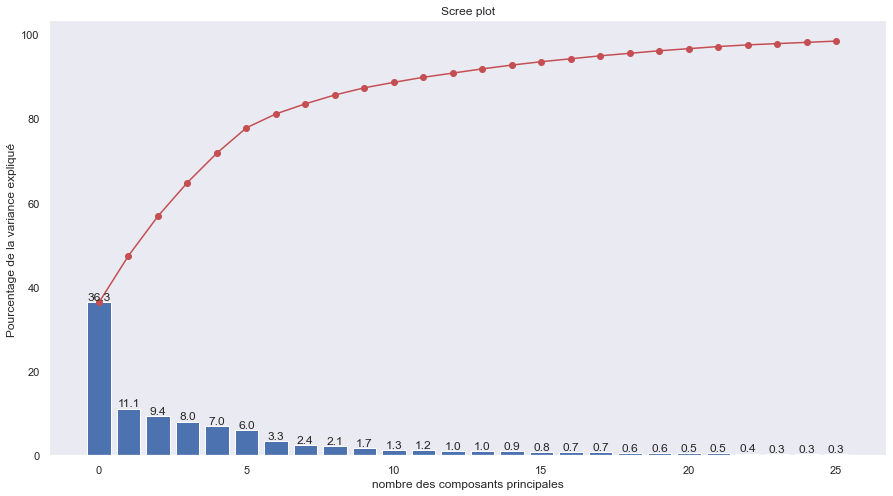

In [66]:
#Accumuler le pourcentage de la variance expliqué  
ycum = np.cumsum(cot_pca) #à pourcentage de variance cumulé 
#dessiner un graphique 
plt.figure(figsize=(15,8))
x = range(len(cot_pca))
plt.bar(x,cot_pca)
plt.plot(x,ycum,"-r", marker='o')
plt.ylabel("Pourcentage de la variance expliqué ")  
plt.xlabel("nombre des composants principales")
plt.title ("Scree plot")
plt.grid()
s=np.array(data['explained variance'])
for i in range(data.shape[0]-1):
    plt.annotate(str(s[i]), xy=(x[i],s[i]), ha='center', va='bottom')

plt.show()



In [67]:
print(" le prémier factoriel couvre une inertie de ", data['cummulative variance'][1], "% et le deuxième plan factoriel couvre une inertie égal à", 
      data['cummulative variance'][3],'%')

 le prémier factoriel couvre une inertie de  47.4 % et le deuxième plan factoriel couvre une inertie égal à 64.8 %


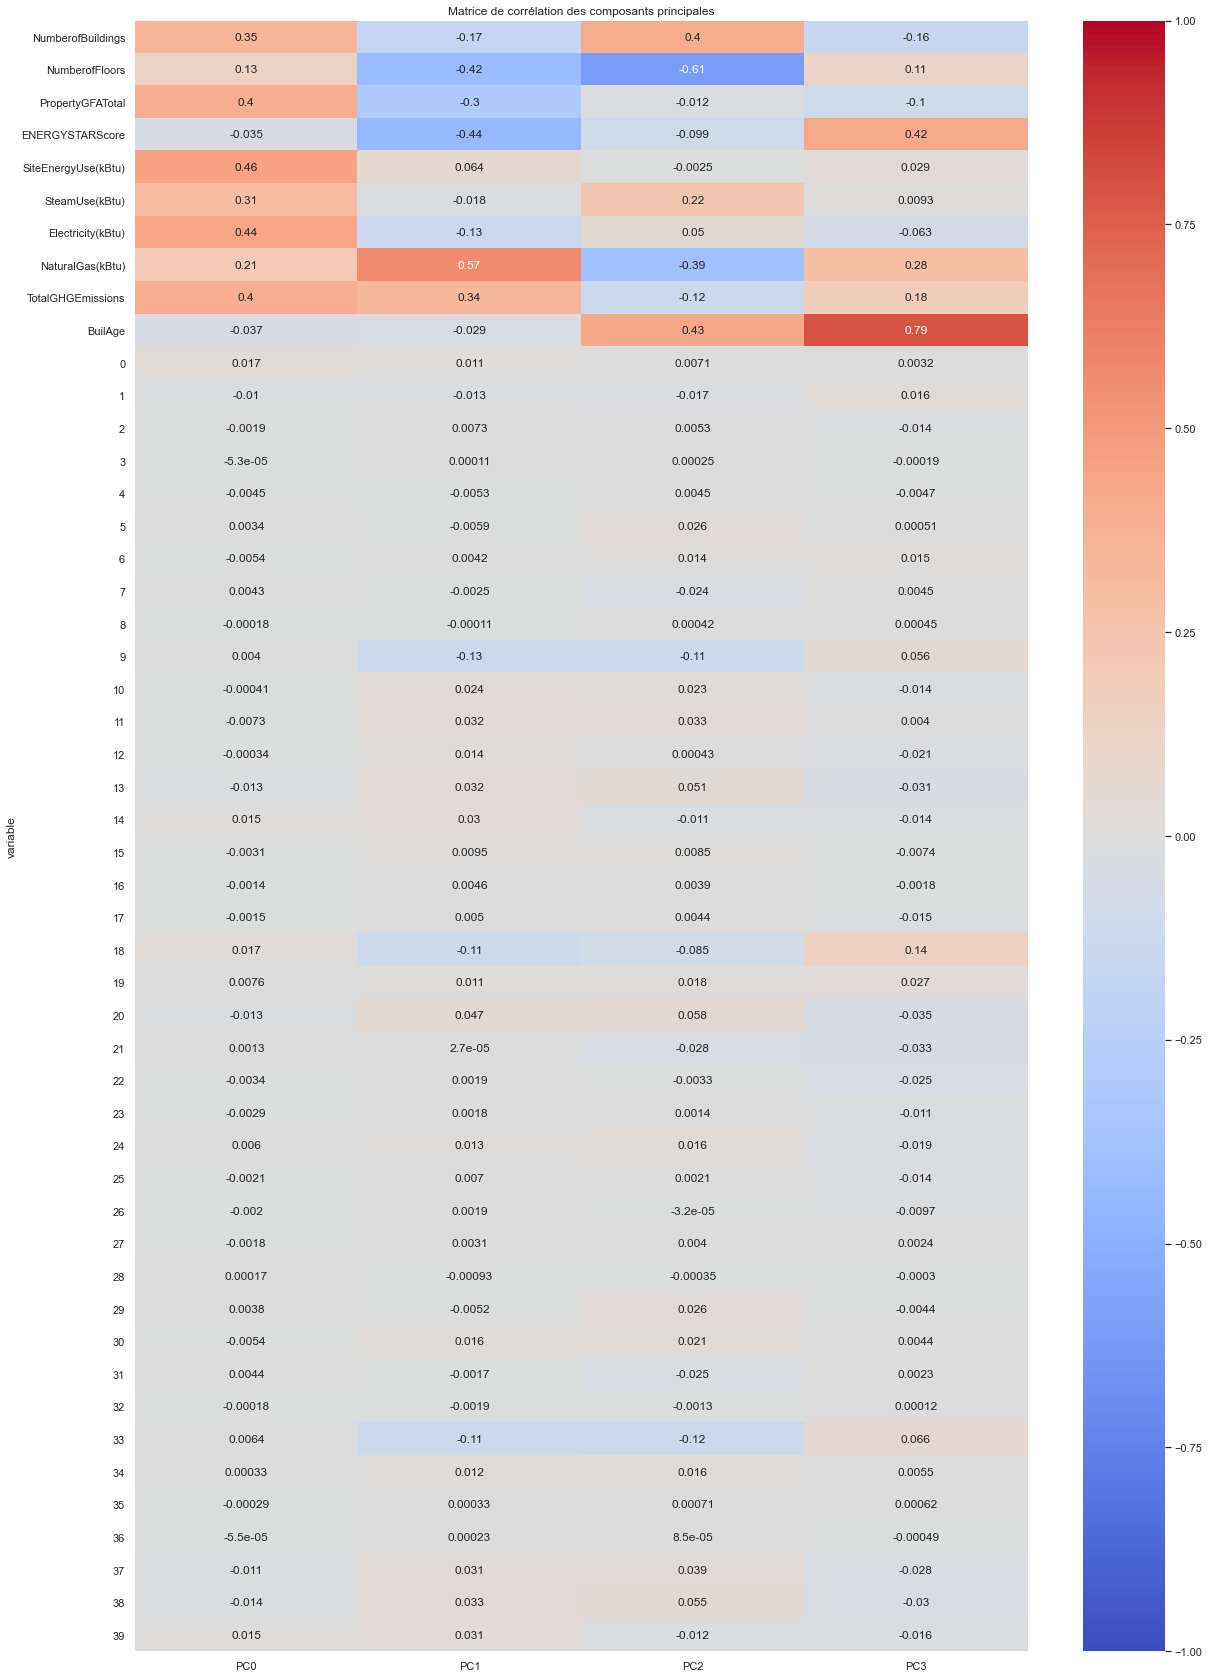

In [68]:
#Retrouver les composants principaux au niveau de chaque axe 
#créer une liste des composants de PC1- PC4
pc_list = ["PC"+str(i) for i in list(range(0, 4))]
df_pca = pd.DataFrame.from_dict(dict(zip(pc_list, pca.components_)))
df_pca ['variable'] = dataset.columns.values
df_pca = df_pca .set_index('variable')
# get correlation matrix plot 
fig, ax = plt.subplots(figsize=(20,30)) 
sns.heatmap(df_pca , annot=True, cmap='coolwarm', ax=ax, vmax=1, vmin=-1)
plt.title("Matrice de corrélation des composants principales")
plt.show()

L’ACP peut être déﬁnie comme la recherche des combinaisons linéaires de plus grande variance, des variables initiales (les valeurs propres).

Les 4 premiers plans factoriels couvrent une inertie à peu près 70%. Une analyse sur PC1 jusqu'a PC4 semble donc nécessaire.

In [69]:
X_projected.shape

(1668, 26)

In [70]:
#Enregistrer dataset après PCA
X_projected.to_csv("C:\\Users\Marwa\Downloads\projet4\\dataset_2016_PCA.csv")